In [1]:
## testing 
## using the 24pt model on the test patients
## using the model on the MR deformed to match the CT


In [2]:
import tensorflow as tf
print(tf.__version__)

1.12.0


In [3]:
import keras
print(keras.__version__)

2.2.2


Using TensorFlow backend.


In [4]:
import sys

In [5]:
#from __future__ import print_function #may need this, just took it out because running the .py from anaconda prompt complained

import cv2   #CMT something to do with computer vision and hardware acceleration. Perhaps linked to GPU?
from keras.models import Model
from keras.layers import Input, Dropout, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

K.set_image_dim_ordering('th')  # Theano dimension ordering in this code


In [6]:
sys.executable

'C:\\Users\\cht17\\AppData\\Local\\Continuum\\anaconda3\\envs\\tensorflowChris\\python.exe'

In [7]:
#THEANO_FLAGS=device=gpu,floatX=float32 #python #my_keras_script.py

In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5479289736861704584
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11130201703
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13315089999413697933
physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:17:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 4053676852
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7613348512913856385
physical_device_desc: "device: 1, name: Quadro P2000, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


In [9]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) #what does this do?!?!?!

In [10]:
import numpy as np
import nibabel as nib
import json

C:\Users\cht17\AppData\Local\Continuum\anaconda3\envs\tensorflowChris\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [11]:
import matplotlib.pyplot as plt

In [12]:
import os
import pylab
from PIL import Image

In [13]:
#TestArrayCT = np.load("D:/CNNdata/SynCT_LargerCohort/Testing/CTtestExcluding31.npy")
TestArrayCT = np.load("D:/CNNdata/SynCT_LargerCohort_v3/Testing/CTtestAll.npy")


In [14]:
#TestArrayMR = np.load("D:/CNNdata/SynCT_LargerCohort/Testing/MRtestExcluding31.npy")
TestArrayMR = np.load("D:/CNNdata/SynCT_LargerCohort_v3/Testing/MRtestAll.npy")

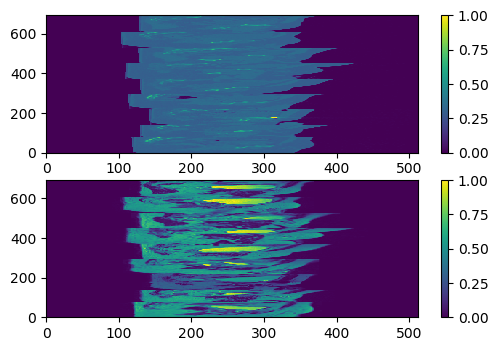

In [15]:

plt.figure(dpi=100)
plt.axes().set_aspect('equal', 'datalim')
n=230
m=n+121
plt.subplot(2,1,1)
plt.pcolormesh(TestArrayCT[:,0,:,n])
plt.colorbar()
plt.subplot(2,1,2)
plt.pcolormesh(TestArrayMR[:,0,:,n])
plt.colorbar()


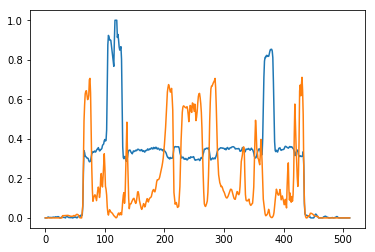

In [16]:
plt.plot(TestArrayCT[0,0,250,:])
plt.plot(TestArrayMR[0,0,250,:])

In [17]:
np.min(TestArrayMR)

0.0

In [18]:
MRminTraining = 0

In [19]:
np.max(TestArrayMR)

1.0

In [20]:
#MRmaxTraining = 14785
MRmaxTraining = 1

In [ ]:
#In v2 we have already normalised the data (HU as per v1 way with 2000HU limit), and MR using min/max values per patient

# HighDens = 2000
# TestArrayCT[TestArrayCT > HighDens] = HighDens
# TestArrayCTNorm=(TestArrayCT/(HighDens+1000)) +(1/3)

In [ ]:
# TestArrayMRNorm=TestArrayMR-np.min(ArrayMR)
# TestArrayMRNorm=TestArrayMRNorm/np.max(ArrayMR)

# TestArrayMRNorm=TestArrayMR-MRminTraining
# TestArrayMRNorm=TestArrayMRNorm/MRmaxTraining


In [ ]:
# plt.figure(dpi=100)
# plt.axes().set_aspect('equal', 'datalim')
# n=230
# m=n+121
# plt.subplot(2,1,1)
# plt.pcolormesh(TestArrayCTNorm[:,0,:,n])
# plt.colorbar()
# plt.subplot(2,1,2)
# plt.pcolormesh(TestArrayMRNorm[:,0,:,n])
# plt.colorbar()

In [21]:
run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

In [22]:
def get_unet():  
    
    inputs = Input((1, image_rows, image_cols)) 
    
    conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    
    D1=Dropout(0.2)(conv1) #need this?
    
    conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(D1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    #now at 256x256
    
    conv2 = Conv2D(64, (5, 5), activation='relu', padding='same')(pool1)
    D2=Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (5, 5), activation='relu', padding='same')(D2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    #now at 128x128

    conv3 = Conv2D(128, (5, 5), activation='relu', padding='same')(pool2)
    D3=Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (5, 5), activation='relu', padding='same')(D3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    #now should be at 64x64
    
    conv4 = Conv2D(256, (5, 5), activation='relu', padding='same')(pool3)
    D4=Dropout(0.2)(conv4)
    conv4 = Conv2D(256, (5, 5), activation='relu', padding='same')(D4)
    
    
    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=2, padding='valid')(conv4), conv3], axis=1)
    conv8 = Conv2D(128, (5, 5), activation='relu', padding='same')(up8)
    D8=Dropout(0.2)(conv8)
    conv8 = Conv2D(128, (5, 5), activation='relu', padding='same')(D8)
    
    
    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=2, padding='valid')(conv8), conv2], axis=1)
    conv9 = Conv2D(64, (5, 5), activation='relu', padding='same')(up9)
    D9=Dropout(0.2)(conv9)
    conv9 = Conv2D(64, (5, 5), activation='relu', padding='same')(D9)

    up10 = concatenate([Conv2DTranspose(32, (2, 2), strides=2, padding='valid')(conv9), conv1], axis=1)
    conv10 = Conv2D(32, (5, 5), activation='relu', padding='same')(up10)
    D10=Dropout(0.2)(conv10)
    conv10 = Conv2D(32, (5, 5), activation='relu', padding='same')(D10)

    conv11 = Conv2D(1, (1, 1), activation='linear')(conv10)
    
    model = Model(input=inputs, output=conv11)
    
    return model

In [23]:
image_rows = 512
image_cols = 512

In [24]:
model = get_unet()

C:\Users\cht17\AppData\Local\Continuum\anaconda3\envs\tensorflowChris\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [25]:
# ModelLocation = 'D:/CNNdata/SynCT_DIR_T2_tse/SynCT_12pt_model/'
# ModelName = '12ptModel.h5'

#ModelLocation = 'D:/CNNdata/SynCT_LargerCohort/TrainedModel/'
#ModelName = '24ptModel.h5'

ModelLocation = 'D:/CNNdata/SynCT_LargerCohort_v3/TrainedModel/'
ModelName = '24ptModelv3.h5'

model.load_weights(os.path.join(str(ModelLocation) + str(ModelName)))

In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 512, 512)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 512, 512) 832         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 512, 512) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 512, 512) 25632       dropout_1[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [27]:
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [29]:
#TotalSlices = np.size(TestArrayCTNorm,0)
TotalSlices = np.size(TestArrayCT,0)
TotalSlices

693

In [30]:
SynCT = np.zeros((TotalSlices,1,512,512), dtype = 'float')
print('-'*30)
print('Predicting CT on MRI data...')
print('-'*30)
#for i in range(0,np.size(TestArrayCTNorm,0)):
for i in range(0,np.size(TestArrayCT,0)):
    #SynCT[i,:,:,:] = model.predict(TestArrayMRNorm[i:i+1,:,:,:], verbose=1)
    SynCT[i,:,:,:] = model.predict(TestArrayMR[i:i+1,:,:,:], verbose=1)

------------------------------
Predicting CT on MRI data...
------------------------------
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


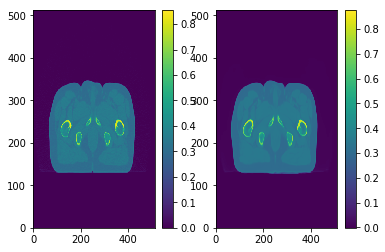

In [31]:
plt.subplot(1,2,1)
#plt.pcolormesh(TestArrayCTNorm[0,0,:,:])
plt.pcolormesh(TestArrayCT[100,0,:,:])
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(SynCT[100,0,:,:])
plt.colorbar()

In [32]:
# convert back to HU
SynCTHU = np.zeros((TotalSlices,1,512,512),dtype=int)
SynCTHU = np.multiply(3000, SynCT-(1/3))

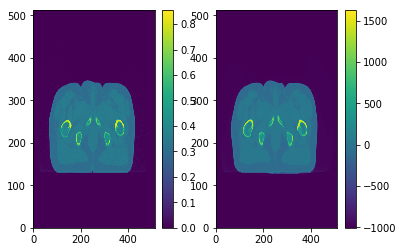

In [33]:
plt.subplot(1,2,1)
plt.pcolormesh(TestArrayCT[100,0,:,:])
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(SynCTHU[100,0,:,:])
plt.colorbar()

In [34]:
np.shape(SynCTHU)

(693, 1, 512, 512)

In [35]:
# StartSlice = [0, 79, 142, 218, 296, 375, 451, 532]
# SlicesPerPatient = [79, 63, 76, 78, 79, 76, 81, 83]
# PatientIDs = [11, 30, 41, 47, 52, 53, 54, 55]

StartSlice = [0, 79, 142, 220, 296, 374, 453, 529, 610]
SlicesPerPatient = [79, 63, 78, 76, 78, 79, 76, 81, 83]
PatientIDs = [11, 30, 31, 41, 47, 52, 53, 54, 55]

In [36]:
i = 5
SynCTHUpatient = SynCTHU[StartSlice[i]:StartSlice[i]+SlicesPerPatient[i],:,:,:]

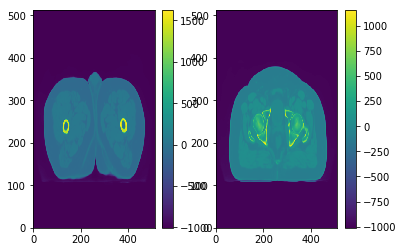

In [37]:
plt.subplot(1,2,1)
plt.pcolormesh(SynCTHUpatient[0,0,:,:])
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(SynCTHUpatient[50,0,:,:])
plt.colorbar()

In [38]:
np.shape(SynCTHU)

(693, 1, 512, 512)

In [39]:
np.shape(TestArrayCT)

(693, 1, 512, 512)

In [40]:
np.save('D:/CNNdata/SynCT_LargerCohort_v3/Testing/' + str(ModelName) + '_allTestPatients.npy', SynCTHU)

In [43]:
len(PatientIDs)

9

In [44]:
for i in range (0,len(PatientIDs)):
    print(i)
    SynCTHUpatient = SynCTHU[StartSlice[i]:StartSlice[i]+SlicesPerPatient[i],:,:,:]

    np.save('D:/CNNdata/SynCT_LargerCohort_v2/Testing/' + str(ModelName) + str(PatientIDs[i]) + '.npy', SynCTHUpatient)

0
1
2
3
4
5
6
7
8


In [ ]:
SynCTpt11 = np.load('D:/CNNdata/SynCT_LargerCohort/Testing/24ptsModelSynCT11.npy')

In [ ]:
SynCTpt30 = np.load('D:/CNNdata/SynCT_LargerCohort/Testing/24ptsModelSynCT30.npy')

In [ ]:
np.shape(SynCTpt11)

In [ ]:
np.shape(SynCTpt30)

In [ ]:
plt.pcolormesh(SynCTpt11[78,0,:,:])
plt.colorbar()

In [ ]:
print('-'*30)
print('Fitting model...')
print('-'*30)
## the input data (MR) and then the mask (CT)
history = model.fit(ArrayMRNorm, ArrayCTNorm, batch_size=1, epochs=100, verbose=1, shuffle=True) #batch size was 6
        #  callbacks=[model_checkpoint])

# #     with open('/trainHistoryDict' + str(i), 'wb') as file_pi:
# #         pickle.dump(history.history, file_pi)
# with open('file' +str(i) +'.json', 'w') as f:
#     json.dump(history.history, f)

In [ ]:
# https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# trying to save the model so that it can be loaded in another script and tested on other data

# serialize model to JSON
model_json = model.to_json()
with open("D:/CNNdata/SynCT_LargerCohort/TrainedModel/24ptModel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("D:/CNNdata/SynCT_LargerCohort/TrainedModel/24ptModel.h5")
print("Saved model to disk")

In [ ]:
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

In [ ]:
niftiRenneMRI = "D:/Renne/T2 HSE_Renne/T2 HSE/patient_pelvisonly/RennePelvis.nii"
imgRenneMRI = nib.load(niftiRenneMRI)
ArrayRenneMRI = np.array(imgRenneMRI.dataobj)

In [ ]:
## will need to get it into the form [slices,0,x,y]
## will need to check that the patient is the same orientation as training data
ArrayRenneMRINormNew = np.zeros((66,1,512,512),dtype=float) #fills the whole array with zeros


In [ ]:
ArrayRenneMRINorm=ArrayRenneMRI-np.min(ArrayRenneMRI)
ArrayRenneMRINorm=ArrayRenneMRINorm/np.max(ArrayRenneMRI)

In [ ]:
np.shape(ArrayRenneMRINorm)

In [ ]:
ArrayRenneMRINorm[256,:,30]

In [ ]:
for i in range(0,66):
    print(i)
    ArrayRenneMRINormNew[i,0,:,:] = ArrayRenneMRINorm[:,:,i]

In [ ]:
slices = np.size(ArrayRenneMRINormNew,0)
slices

In [ ]:
plt.pcolormesh(SynCT[30,0,:,:])
plt.colorbar()

In [ ]:
# convert back to HU
SynCTHU = np.zeros((slices,1,512,512),dtype=int)
SynCTHU = np.multiply(3000, SynCT-(1/3))

np.save('LOO12epochs100SynCT' + str(i) + '.npy', SynCTHU)

In [ ]:
plt.pcolormesh(SynCTHU[30,0,:,:])
plt.colorbar()

In [ ]:
plt.pcolormesh(ArrayRenneMRINormNew[30,0,:,:])
plt.colorbar()

In [ ]:
for i in range (0,datasets): # outer loop to create all synCTs in a leave-one-out method
    model = get_unet() # this resets the model each time round.
    model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error', metrics=['mae'])
    
    TrainValidTest = np.zeros((datasets),dtype=int) # array that determines if dataset is for training, validation or testing
    TrainValidTest[i] = 2 # sets the ith dataset as the testing array, all the rest are zeros (i.e. training)
    print(TrainValidTest)
    
    TrainCT = np.zeros((Tslices,1,512,512),dtype=int) #fills the whole array with zeros
    TrainMR = np.zeros((Tslices,1,512,512),dtype=int) #fills the whole array with zeros
    ValidCT = np.zeros((Vslices,1,512,512),dtype=int) #fills the whole array with zeros
    ValidMR = np.zeros((Vslices,1,512,512),dtype=int) #fills the whole array with zeros
    TestCT = np.zeros((Xslices,1,512,512),dtype=int) #fills the whole array with zeros
    TestMR = np.zeros((Xslices,1,512,512),dtype=int) #fills the whole array with zeros

    TrainTicker = 0
    ValidTicker = 0
    TestTicker = 0

    for j in range(0,datasets): # to create one SynCT
         
        if TrainValidTest[j] == 0:
            print(TrainValidTest[j])
            print("Train")
            for slice in range(startslice[j],stopslice[j]+1):
                TrainCT[TrainTicker,0,:,:] = ArrayCT[slice,0,:,:] # note that these lines had ArrayCT[slice,0:,:] before
                TrainMR[TrainTicker,0,:,:] = ArrayMR[slice,0,:,:] # but somehow still seemed to work
                TrainTicker = TrainTicker + 1
        if TrainValidTest[j] == 1:
            print(TrainValidTest[j])
            print("Valid")
            for slice in range(startslice[j],stopslice[j]+1):
                # k = startslice[j] + slice
                ValidCT[ValidTicker,0,:,:] = ArrayCT[slice,0,:,:] # note that these lines had ArrayCT[slice,0:,:] before
                ValidMR[ValidTicker,0,:,:] = ArrayMR[slice,0,:,:] # but somehow still seemed to work
                ValidTicker = ValidTicker + 1    
        if TrainValidTest[j] == 2:
            print(TrainValidTest[j])
            print("Test")
            for slice in range(startslice[j],stopslice[j]+1):
                # k = startslice[j] + slice
                TestCT[TestTicker,0,:,:] = ArrayCT[slice,0,:,:] # note that these lines had ArrayCT[slice,0:,:] before
                TestMR[TestTicker,0,:,:] = ArrayMR[slice,0,:,:] # but somehow still seemed to work
                TestTicker = TestTicker + 1
        
    TrainCT = TrainCT[0:TrainTicker,:,:,:] # this crops the array to just the slices that have data
    TrainMR = TrainMR[0:TrainTicker,:,:,:] # I guess this could be managed at the start somehow
    ValidCT = ValidCT[0:ValidTicker,:,:,:] # but they would need to be different sizes depending on
    ValidMR = ValidMR[0:ValidTicker,:,:,:] # which dataset was left out.
    TestCT = TestCT[0:TestTicker,:,:,:]
    TestMR = TestMR[0:TestTicker,:,:,:]
    
    print("Replace all elements of CT array with 2000 which are greater than 2000HU")
    print("This will set all of the metal to to bone density")
    print("Could set it to air or tissue instead I guess but hip implants should be set to bone at least")
    HighDens = 2000
    TrainCT[TrainCT > HighDens] = HighDens
    
    # NORMALISATION

    if TrainTicker > 0:
        TrainCTNorm=(TrainCT/(HighDens+1000)) +(1/3)
        TrainMRNorm=TrainMR-np.min(TrainMR)
        TrainMRNorm=TrainMRNorm/np.max(TrainMR)
    
    if ValidTicker > 0:
        ValidCTNorm=(ValidCT/(HighDens+1000)) +(1/3)
        ValidMRNorm=ValidMR-np.min(ValidMR)
        ValidMRNorm=ValidMRNorm/np.max(ValidMR)

    if TestTicker > 0:
        TestCTNorm=(TestCT/(HighDens+1000)) +(1/3)
        TestMRNorm=TestMR-np.min(TestMR)
        TestMRNorm=TestMRNorm/np.max(TestMR)
        
    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    ## the input data (MR) and then the mask (CT)
    history = model.fit(TrainMRNorm, TrainCTNorm, batch_size=1, epochs=100, verbose=1, shuffle=True) #batch size was 6
            #  callbacks=[model_checkpoint])
    
#     with open('/trainHistoryDict' + str(i), 'wb') as file_pi:
#         pickle.dump(history.history, file_pi)
    with open('file' +str(i) +'.json', 'w') as f:
        json.dump(history.history, f)
    
    print('-'*30)
    print('Predicting CT on test data...')
    print('-'*30)
    SynCT = model.predict(TestMRNorm, verbose=1)
    
    # convert back to HU
    SynCTHU = np.zeros((TestTicker,1,512,512),dtype=int)
    SynCTHU = np.multiply(3000, SynCT-(1/3))
    
    np.save('LOO12epochs100SynCT' + str(i) + '.npy', SynCTHU)
    

In [ ]:
print(np.shape(TrainMR))
print(np.shape(TrainMRNorm))
print(np.shape(ValidMR))
#print(np.shape(ValidMRNorm))
print(np.shape(TestMR))
print(np.shape(TestMRNorm))

In [ ]:
stopslice[j]
s010

In [ ]:
plt.subplot(211)  
plt.plot(history.history['mean_absolute_error'])  
# plt.plot(history.history['val_acc'])  
plt.title('mean absolute error')  
plt.ylabel('MAE')  
plt.xlabel('epoch')  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.title('loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')

In [ ]:
## need to find out how to read a json file to plot the loss and MAE

In [ ]:
import codecs

In [ ]:
with codecs.open('file.json', 'r', encoding='utf-8') as f:
    n = json.loads(f.read())
#return n

In [ ]:
n